# Dogbreed Image Classifier

## Review: easy steps to train a world-class image classifier

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use Test Time Augmentation (TTA) for test predictions
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
#torch.cuda.set_device(1)  # why did Jeremy use this and why does this fail??
# torch.cuda.set_device(0)  # not needed 
# torch.cuda.device_count() # not needed

In [4]:
torch.cuda.current_device() # not needed

0

In [5]:
PATH = "data/dogbreeds/"

sz=224

arch=resnext101_64

bs=58 #batch size

label_csv = f'{PATH}labels.csv'

## Create Test Image database

Since no validation folder, get 20% of the test images at random with the call to get_cv_idxs(). This method returns the indexes for cross validation; defaults to retun 20% of the directory at random. This 20% method shouldn't be used for small data sets.

val_idxs is passed into ImageClassiferData object.

In [6]:
n = len(list(open(label_csv)))-1 # get length of csv file

val_idxs = get_cv_idxs(n) # val_idxs is the number of the indexes to the training set

#val_idxs = get_cv_idxs(n, val_pct=1.0) # This returns 100% of the dataset

#val_idxs     #print out a sample of the content in val_idxs
#len          #print out len
#len(val_idxs) #print out length of val_idxs array

In [7]:
# Uncomment the below if youb need to reset your precomputed activations
#!rm -rf {PATH}tmp

## Explore the data

In [8]:
!ls {PATH}

all.zip     sample_submission.csv  test.zip  train
labels.csv  test		   tmp	     train.zip


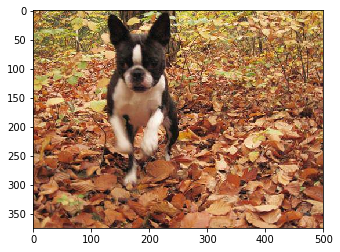

In [9]:
# Display one of the images
files = !ls {PATH}train | head

img = plt.imread(f'{PATH}train/{files[0]}')

plt.imshow(img);

In [ ]:
# Display contents of csv file

label_df = pd.read_csv(label_csv) # a pandas read_csv function

label_df.head() # outputs the first several entries in the csv file formatted

In [ ]:
# create pivot table to see how many of each kind are in the csv and img database
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

In [ ]:
# the data object gives you acces to the file names
fn = PATH+data.trn_ds.fnames[0] 

#fn

In [ ]:
img = PIL.Image.open(fn)

#img

In [ ]:
# Display image size
img.size

In [ ]:
# Create a size dictionary for data examination
# This matches the name of the file to the size
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [ ]:
row_sz,col_sz = list(zip(*size_d.values()))

In [ ]:
# Convert the data into a numpy array
row_sz = np.array(row_sz) 

col_sz = np.array(col_sz)

In [ ]:
row_sz[:10] # print the first 10 row sizes

In [ ]:
# matplotlib Histogram the row_sz data 
plt.hist(row_sz)

In [ ]:
# Zoom in on histogram data - i.e. display those w/row size < 1000
plt.hist(row_sz[row_sz<1000])

In [ ]:
# matplotlib Histogram the data
plt.hist(col_sz)

In [ ]:
# Zoom in on histogram data - i.e. display those w/row size < 1000
plt.hist(col_sz[col_sz<1000])

In [ ]:
# The Pretrained ConvLearner object
learn = ConvLearner.pretrained(arch, data, precompute=True)

## 1. Enable Data Aug.  & Create Data Object

In [10]:
def get_data(sz, bs):
    # Enable/do data transformation on training set
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

    # The cleaned up object which holds our data
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, test_name='test', 
                                        val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    
    return data if sz>300 else data.resize(340, 'tmp')

In [11]:
data = get_data(sz, bs) # if runtime errors on cuda ordinal number then restart kernel

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [12]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [13]:
learn.fit(1e-2, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       0.90937  0.37961  0.9114 ]                        
[ 1.       0.4304   0.30847  0.91571]                        
[ 2.       0.31042  0.30316  0.91667]                        
[ 3.       0.22599  0.28558  0.92193]                        
[ 4.       0.20883  0.27848  0.92098]                        



## Augment

In [14]:
from sklearn import metrics

In [15]:
data = get_data(sz,bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

## 3. Train last layer from pre-computed model

In [16]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [17]:
learn.fit(1e-2,2) # train last layer from pre-computed model?

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.12315  0.43314  0.91092]                       
[ 1.       0.5215   0.32113  0.91379]                        



In [18]:
learn.precompute=False # this will slow things way down

In [19]:
learn.fit(1e-2, 5, cycle_len=1) # fit/traing model to training dataset

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       0.45194  0.2712   0.9181 ]                        
[ 1.       0.40942  0.25728  0.92146]                        
[ 2.       0.3744   0.25125  0.91954]                        
[ 3.       0.33693  0.24366  0.92146]                        
[ 4.       0.31752  0.23689  0.92433]                        



## 2. Find highest learning rate where loss is still increasing

We did step 3 early just to get an idea of how well the model does on our dataset and found that 1e-2 is a great learning rate so skip this slow step below.

In [ ]:
# lrf=learn.lr_find() # Not helpful this time

Save the trained model that was done on the 244x244 size images and load it back in.

In [21]:
learn.save('224_pre')

In [22]:
learn.load('224_pre')

## Increase Size of images

In [23]:
# Recreate our training data object, but with larger (299x299) images
learn.set_data(get_data(299, bs)) # continue training, but now with 299 size

learn.freeze() # this ensures last layer is frozen i.e. it won't get retrained

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

Notice that the loss of the training set (output of cell below) is high than the loss of the test set! This is an "underfit" condition, so there is still more room for optimization. The root issue here is that the model is not spending enough time training on it's specified learning rate. Solution is to increase cycle_mult to 2 after this.

In [24]:
# Retrain with 3 epochs and 299 size images
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.31344  0.23133  0.92912]                        
[ 1.       0.3003   0.23061  0.9272 ]                        
[ 2.       0.29046  0.22548  0.92816]                        



In [25]:
# Since the obove worked well, try again with increased cycle_mult
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.27235  0.22376  0.92768]                        
[ 1.       0.26462  0.21479  0.92912]                        
[ 2.       0.24302  0.21392  0.92768]                        
[ 3.       0.22719  0.2237   0.92529]                        
[ 4.       0.22299  0.21747  0.9272 ]                        
[ 5.       0.19726  0.21259  0.92672]                        
[ 6.       0.18923  0.21044  0.92577]                        



## 4. Train last layer w/Data Aug.

In [28]:
# Print out metrics
log_preds,y = learn.TTA() # enable test time augmentation
log_preds
#probs = np.exp(log_preds)

#accuracy(log_preds, y), metrics.log_loss(y, probs)

  0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
learn.save('299_pre')

In [30]:
learn.load('299_pre')

In [26]:
learn.fit(1e-2, 1, cycle_len=2) # retrain with TTA on. Not sure why cycle_len is 2 now

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       0.20247  0.21369  0.92481]                        
[ 1.       0.20293  0.2169   0.92577]                        



In [ ]:
learn.save('299_pre')

In [ ]:
# Print out metrics
log_preds,y = learn.TTA() # enable test time augmentation

probs = np.exp(log_preds)

accuracy(log_preds, y), metrics.log_loss(y, probs)

## 5. Unfreeze all layers

In [ ]:
# learn.unfreeze() # doesn't help with this dataset since it uses a subset of imagenet

## 6. Set earlier layers to 3x-10x lower learning rate than next higher layer

In [ ]:
lr=np.array([1e-4,1e-3,1e-2]) #differential learning rates

learn.fit(lr, 3, cycle_len=1, cycle_mult=2) #cycle_mult=2 needed for resnet34

In [ ]:
learn.sched.plot()

In [ ]:
learn.save('224_all')

In [ ]:
learn.load('224_all')

## 7. Use Test Time Augmentation for Training Test Predictions

In [ ]:
# Check predictions at this point
log_preds,y = learn.TTA()
accuracy(log_preds,y)

## 8. Find the optimal learning rate again (lr_find)

## 9. Train full network with cycle_mult=2 until over-fitting